In [1]:
import numpy as np
import pandas as pd
import random
import pickle
from tqdm.notebook import tqdm

import netsurfp2 as nsp2

from structure.utils import AA, to_onehot

In [2]:
AMINO_ACIDS = AA = 'ACDEFGHIKLMNPQRSTVWY'
AA_INDEX = {k:i for i,k in enumerate(AA)}

In [3]:
DATASET = "PF00397"
DATA = "/home/cyril/Documents/These/data"

## PFAM sequence extraction

In [4]:
from structure.data_extraction import from_fasta_to_df, from_df_to_fasta

In [5]:
filename = 'aligned.fasta'
proteins_df = from_fasta_to_df(f"{DATA}/{DATASET}/{filename}")
proteins_df = proteins_df.drop_duplicates(subset = ["seq"])
proteins_df.seq = proteins_df.aligned_seq.apply(lambda s : "".join([c for c in s if c in AA]))
proteins_df["length"] = proteins_df.seq.apply(lambda seq : len(seq))
# from_df_to_fasta(proteins_df, f"{DATA}/{DATASET}")

### Cluster

In [6]:
!mmseqs easy-cluster "{DATA}/{DATASET}/unaligned.fasta" "{DATA}/{DATASET}/tmp/clusters.tsv" "{DATA}/{DATASET}/tmp" --min-seq-id 0.7

easy-cluster /home/cyril/Documents/These/data/PF00397/unaligned.fasta /home/cyril/Documents/These/data/PF00397/temp/clusters.tsv /home/cyril/Documents/These/data/PF00397/tmp --min-seq-id 0.7 

MMseqs Version:                     	bbd3c2bb77492f1a852251aaa1ea8624d72bffed
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	4
K-mer size                          	0
K-score                             	2147483647
Alphabet size                       	21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues      

[=================================================================] 100.00% 9.90K 0s 1ms      

Time for read in: 0h 0m 0s 178ms
Total time: 0h 0m 0s 220ms

Size of the sequence database: 9904
Size of the alignment database: 9904
Number of clusters: 3367

Writing results 0h 0m 0s 12ms
Time for merging to pre_clust: 0h 0m 0s 107ms
Time for processing: 0h 0m 0s 489ms
createsubdb /home/cyril/Documents/These/data/PF00397/tmp/2750728949833174504/clu_tmp/11756354771537127490/linclust/3771597180686387089/order_redundancy /home/cyril/Documents/These/data/PF00397/tmp/2750728949833174504/input /home/cyril/Documents/These/data/PF00397/tmp/2750728949833174504/clu_tmp/11756354771537127490/linclust/3771597180686387089/input_step_redundancy -v 3 --subdb-mode 1 

Time for merging to input_step_redundancy: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 2ms
createsubdb /home/cyril/Documents/These/data/PF00397/tmp/2750728949833174504/clu_tmp/11756354771537127490/linclust/3771597180686387089/order_redundancy 

Index table k-mer threshold: 154 at k-mer size 6 
Index table: counting k-mers
[=================================================================] 100.00% 3.21K 0s 19ms
Index table: Masked residues: 17


Index table: fill
[=================================================================] 100.00% 3.21K 0s 29ms


Index statistics
Entries:          54202
DB size:          488 MB
Avg k-mer size:   0.000847
Top 10 k-mers
    WERDGR	90
    GRYVNT	72
    YYDNTT	67
    VDNRTW	46
    YVHTTT	43
    GRYYVT	37
    PYVHRT	32
    GRYYIT	29
    LPGERT	28
    FIHTTT	26
Time for index table init: 0h 0m 0s 613ms
Process prefiltering step 1 of 1

k-mer similarity threshold: 154
Starting prefiltering scores calculation (step 1 of 1)
Query db start 1 to 3206
Target db start 1 to 3206
[=================================================================] 100.00% 3.21K 0s 15ms     
[================================================================>] 99.63% 3.19K eta 0s       
3.423607 k-mers per position
105 DB matches per sequence
0 overflows
0 queries produce too much hits (truncated result)
16 sequences passed prefiltering per query sequence
20 median result list length
0 sequences with 0 size result lists
Time for merging to pref_step0: 0h 0m 0s 131ms
Time for processing: 0h 0m 1s 360ms
align /home/cyril/Documents/

In [7]:
proteins_df["cluster"] = pd.read_table(f"{DATA}/{DATASET}/tmp/clusters.tsv_cluster.tsv", names=["cluster", "id"]).set_index("id").cluster
weights = 1/proteins_df.cluster.value_counts()
proteins_df["weights"] = proteins_df.cluster.apply(lambda c : weights[c])

In [8]:
proteins_df.cluster.value_counts()

A0A1I8HY38_9PLAT/122-151    328
A0A0V1HRK9_9BILA/324-357    272
A0A0A1PJE6_9FUNG/304-333    140
A0A166K038_9HOMO/6-35       137
H9G711_ANOCA/547-576        126
                           ... 
A0A1J4JVH3_9EUKA/42-67        1
A0A250X375_9CHLO/47-74        1
H2YKZ5_CIOSA/19-48            1
A0A0L8I383_OCTBM/7-38         1
L1JDR9_GUITH/582-612          1
Name: cluster, Length: 2320, dtype: int64

In [9]:
from random import shuffle

def split_train_val_set(df, ratio = 0.1):
    max_size = ratio*len(df)
    val = []
    clusters = list(df.cluster.unique())
    shuffle(clusters)
    for c in clusters:
        val += list(df[df.cluster == c].index)
        if len(val) > max_size:
            break
    df["is_val"] = [int(c in val) for c in df.index]

In [10]:
split_train_val_set(proteins_df)

In [11]:
pickle.dump(list(proteins_df.index), open(f"{DATA}/{DATASET}/index.pkl", "wb"))
pickle.dump(list(proteins_df.is_val), open(f"{DATA}/{DATASET}/is_val.pkl", "wb"))
pickle.dump(list(proteins_df.weights), open(f"{DATA}/{DATASET}/weights.pkl", "wb"))

## Build HMM profile

In [40]:
from structure.data_extraction import process_msa

In [41]:
!hhmake -i "{DATA}/{DATASET}/aligned.fasta" -M 100

- 19:44:51.016 INFO: /home/cyril/Documents/These/data/PF00397/aligned.fasta is in A2M, A3M or FASTA format

- 19:44:51.052 INFO: NOTE: Use the '-add_cons' option to calculate a consensus sequence as first sequence of the alignment with hhconsensus or hhmake.



In [42]:
with open(f"{DATA}/{DATASET}/aligned.fasta") as f:
    protlist = nsp2.parse_fasta(f)
uni_idx = [x.split("_")[1] for x in protlist.keys()]

In [43]:
hhm_name = f"{DATA}/{DATASET}/aligned.hhm"
dataset = dict()
# protlist = {k:v for k,v in random.sample(protlist.items(), 2000)}
for k,(_,v) in tqdm(protlist.items()):
    prof = process_msa(v, hhm_name)["profile"]
    idx = np.where(prof[:,:20].sum(1))
    dataset[k] = prof[idx]

A Jupyter Widget

In [44]:
pickle.dump(dataset, open(f"{DATA}/{DATASET}/hmm.pkl", "wb"))

### GFP

In [11]:
with open(f"{DATA}/{DATASET}/aligned.fasta") as f:
    protlist = nsp2.parse_fasta(f)
new_protlist = dict()
for k,v in protlist.items():
    if k.split("_")[1] == "P42212":
        new_protlist[k]= v
protlist = new_protlist
uni_idx = [x.split("_")[1] for x in protlist.keys()]

In [14]:
AMINO_ACIDS = AA = 'ACDEFGHIKLMNPQRSTVWY*'
AA_INDEX = {k:i for i,k in enumerate(AA)}

In [4]:
S = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
S = [c for c in S]

df = pd.read_csv(f"{DATA}/{DATASET}/amino_acid_genotypes_to_brightness.tsv", sep = "\t")
nodes = ["".join(S)]
for x in df.aaMutations.values:
    seq = S.copy()
    if type(x) is not str:
        continue
    for mut in x.split(":"):
        aa, pos = mut[-1], int(mut[2:-1])+1
        seq[pos] = aa
    nodes.append("".join(seq))
df["seq"] = nodes
df.seq = df.seq.apply(lambda s : s[5:-11])

In [15]:
HMM = dataset['0012_P42212_6-227']
hmms = []
for i, s in enumerate(df.seq.values):
    seq = to_onehot([AA_INDEX[x] for x in s], (None,21))
    idx = np.where(np.argmax(seq,1) != 20)[0]
    hmm = np.copy(HMM)
    hmm[:,:20] = seq[:,:20]
    hmm = hmm[idx]
    hmms.append(hmm)

In [16]:
hmms = np.array([[AA_INDEX[x] for x in s] for s in df.seq.values])

In [36]:
from sklearn.neighbors import kneighbors_graph
g = kneighbors_graph(hmms, 5, mode = "distance", metric = "hamming")

In [33]:
df

,aaMutations,uniqueBarcodes,medianBrightness,std,seq
0,NaN,3645,3.719212,0.106992,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
1,SA108D,1,1.301030,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
4,SA108G,2,3.708478,0.020613,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
...,...,...,...,...,...
54020,SY90N:SN103S:SI169F,1,1.552090,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
54021,SY90N:SQ175L:SL205Q:ST228A:SM231V,1,1.301030,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
54022,SY90R:SI150N:SN196S,1,1.301030,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
54023,SY90R:SI165T:SL234P,1,1.301517,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...


In [37]:
import networkx as nx
G = nx.Graph(g)

In [11]:
pickle.dump({f"{i}_bright_{k}":v for i,(k,v) in enumerate(zip(df.medianBrightness, hmms))}, 
            open(f"{DATA}/{DATASET}/hmm_spec.pkl", "wb"))

In [19]:
# structfam["P42212"] = pdb, pfam, c, start, end
# sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
# ss = to_onehot([abc_codes[x] for x in sse], (None,3))
# ss = np.pad(ss, ((1,1),(0,0)), "constant")
# dss = (ss[1:] - ss[:-1])
# cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
# bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
# patterns[pfam] = np.argmax(bbox[:,2:],1)

## Secondary Structure Extraction

In [45]:
pdb_to_uniprot = pd.read_csv(f"{DATA}/cross/uniprot_pdb.csv", skiprows = 2, names = ["uni","pdb"])
uni = []
pdb = []
i = 0
for x in pdb_to_uniprot.itertuples():
    for pdbid in x.pdb.split(";"):
        pdb.append(str.upper(pdbid))
        uni.append(x.uni)
        
pdb_uniprot = pd.DataFrame(columns = ["uni", "pdb"])
pdb_uniprot["uni"] = uni
pdb_uniprot["pdb"] = pdb
pdb_uniprot = pdb_uniprot.drop_duplicates("pdb")
pdb_uniprot.index = pdb_uniprot.pdb 
del pdb_to_uniprot

In [46]:
mapping = pd.read_table(f"{DATA}/cross/pdb_to_pfam.txt")
mapping["PFAM_ID"] = mapping.PFAM_ACC.apply(lambda x : x.split(".")[0])
fam = mapping[mapping.PFAM_ID == DATASET]
structfam = dict()
for x in fam.itertuples():
    try:
        structfam[pdb_uniprot.loc[x.PDB_ID].uni]= (x.PDB_ID, 
                          pdb_uniprot.loc[x.PDB_ID].uni, 
                          x.CHAIN_ID, 
                          int(x.PdbResNumStart), 
                          int(x.PdbResNumEnd))
    except:
        print(x)

Pandas(Index=86021, PDB_ID='2NC6', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=90862, PDB_ID='1E0M', CHAIN_ID='A', PdbResNumStart='4', PdbResNumEnd='33', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=8.4e-13, PFAM_ID='PF00397')
Pandas(Index=137466, PDB_ID='2NC3', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=171206, PDB_ID='2NC5', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=186450, PDB_ID='2NC4', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=226508, PDB_ID='1YMZ', CHAIN_ID='A', PdbResNumStart='3', Pd

## Pattern Builds

In [47]:
from structure.data_extraction import fetch_PDB

In [48]:
from structure.utils import *

patterns = dict()
for pdb, pfam, c, start, end in structfam.values():
    try:
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        ss = to_onehot([abc_codes[x] for x in sse], (None,3))
        ss = np.pad(ss, ((1,1),(0,0)), "constant")
        dss = (ss[1:] - ss[:-1])
        cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
        bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
        patterns[pfam] = np.argmax(bbox[:,2:],1)
    except:
        print(pdb, pfam, c, start, end)

5CQ2 Q96J02 A 480 509
6J1X Q9H0M0 B 506 535


In [49]:
n_patterns = []
c_patterns = []
for k,pat in patterns.items():
#     if k not in uni_idx:
#         continue
    print(str(structfam[k])+" :")
    char_pat= "".join(["abc"[x] for x in pat])
    if len(char_pat) and char_pat not in c_patterns:
        c_patterns.append(char_pat)
        n_patterns.append(list(pat))

('1YIU', 'Q8C863', 'A', 6, 35) :
('2MPT', 'Q96PU5', 'A', 479, 508) :
('5VTJ', 'Q13526', 'A', 7, 37) :
('2LTV', 'O15105', 'A', 232, 261) :
('2N8T', 'P08050', 'A', 6, 35) :
('2YSE', 'Q96QZ7', 'A', 14, 43) :
('6RSS', 'O00308', 'A', 75, 104) :
('5YDX', 'P46937', 'A', 16, 45) :
('2MWF', 'O14776', 'A', 434, 460) :
('2LB2', 'P84022', 'A', 367, 396) :
('1WR7', 'Q8CFI0', 'A', 9, 38) :
('2OEI', 'O00213', 'A', 255, 283) :
('1YWI', 'O75400', 'A', 17, 42) :
('2LB0', 'Q15797', 'A', 236, 265) :
('2MDI', 'Q9BYW2', 'A', 17, 46) :
('4N7F', 'P46934', 'A', 423, 452) :
('1WMV', 'Q9NZC7', 'A', 12, 41) :
('2DK1', 'O75554', 'A', 9, 34) :
('1EG4', 'P11532', 'A', 59, 86) :
('2JX8', 'Q9H4Z3', 'A', 7, 36) :
('2RLY', 'Q05860', 'W', 6, 33) :
('3OLM', 'P0CG63', 'A', 389, 418) :
('2EZ5', 'Q24139', 'W', 531, 560) :
('2JV4', 'Q5AZY5', 'A', 7, 37) :
('2L4J', 'E7FH70', 'A', 188, 217) :
('2YSB', 'Q8VEB2', 'A', 12, 41) :
('2N8S', 'Q62940', 'A', 6, 35) :
('1I8G', 'P30311', 'B', 2, 32) :
('2YSC', 'O95704', 'A', 9, 37) :
('2M

In [50]:
c_patterns

['cbcbcbc',
 'bcbcbc',
 'cbcbcbca',
 'cbc',
 'acaca',
 'acbcbcbc',
 'bcac',
 'cbcac',
 'cbcbc',
 'cbcbca',
 'bcbcac',
 'bcbcbca']

In [51]:
pickle.dump((n_patterns, c_patterns, list(patterns.keys())), open(f"{DATA}/{DATASET}/patterns.pkl", "wb"))

## Vizualization

In [52]:
from structure.graphics import visualize_secondary_structure
from structure.data_extraction import fetch_PDB
import matplotlib.pyplot as plt

1YIU


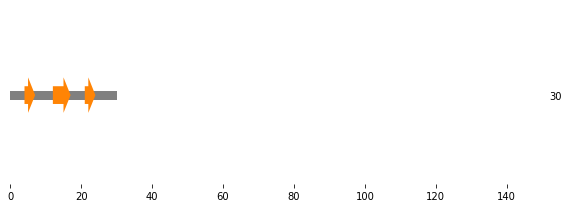

2MPT
2MPT Q96PU5 A 479 509
5VTJ


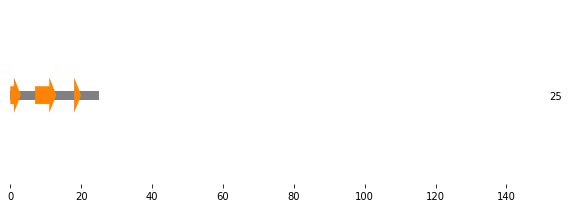

2LTV
2LTV O15105 A 232 262
2N8T


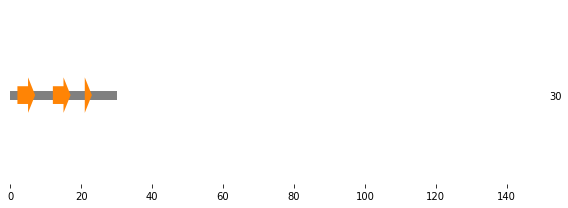

2YSE


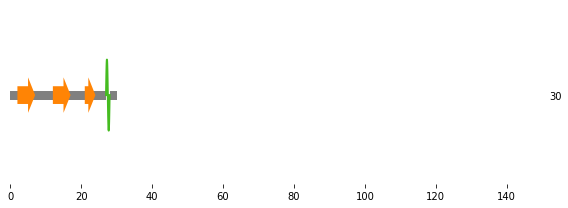

6RSS


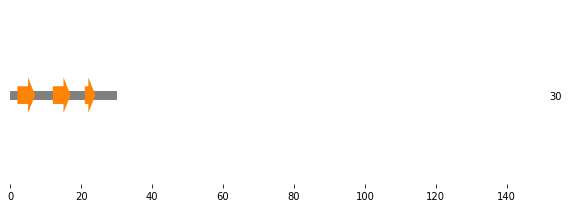

5CQ2
5CQ2 Q96J02 A 480 510
5YDX


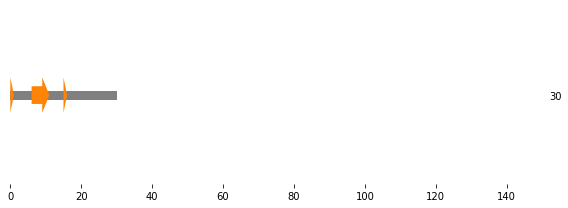

2MWF
2MWF O14776 A 434 461
2LB2
2LB2 P84022 A 367 397
1WR7


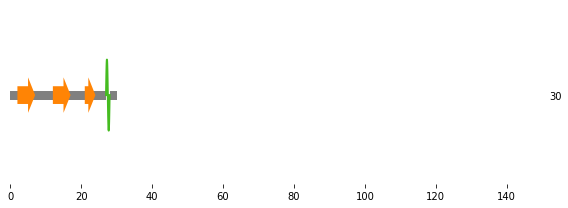

2OEI
2OEI O00213 A 255 284
1YWI


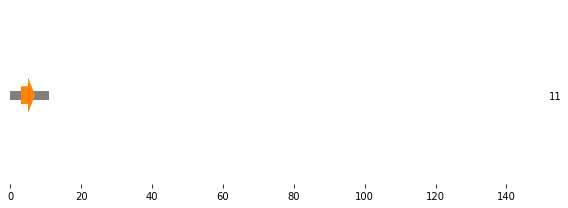

2LB0
2LB0 Q15797 A 236 266
2MDI


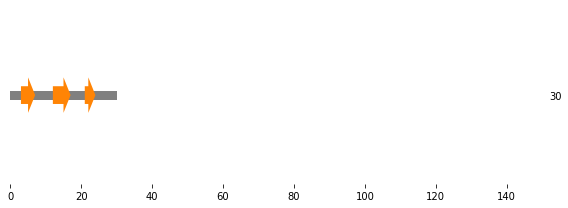

4N7F
4N7F P46934 A 423 453
1WMV


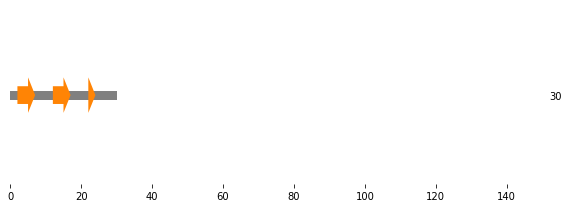

2DK1


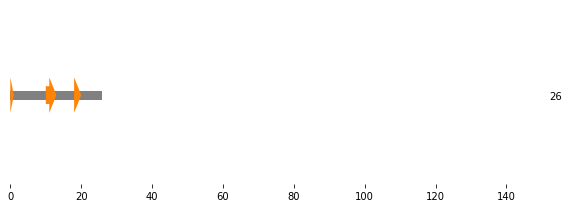

1EG4


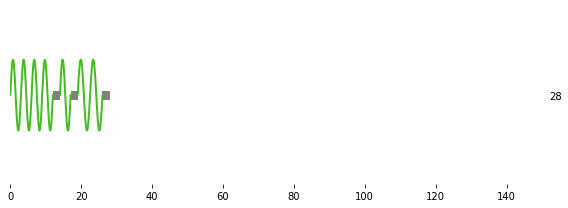

2JX8


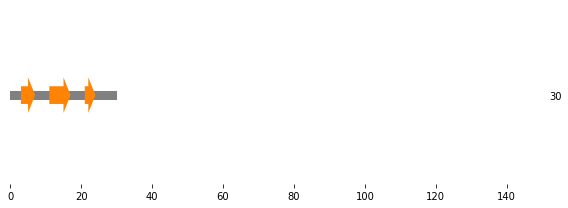

2RLY


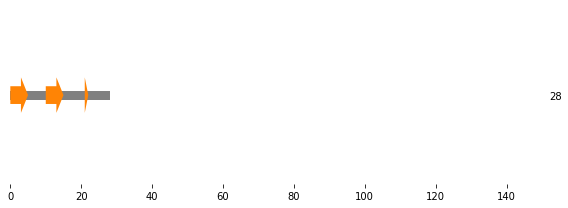

6J1X
6J1X Q9H0M0 B 506 536
3OLM


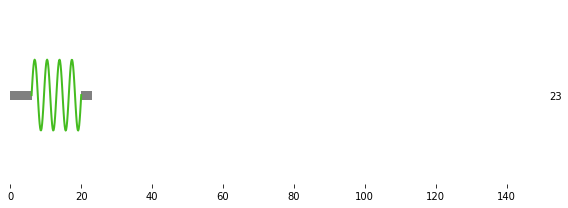

2EZ5
2EZ5 Q24139 W 531 561
2JV4


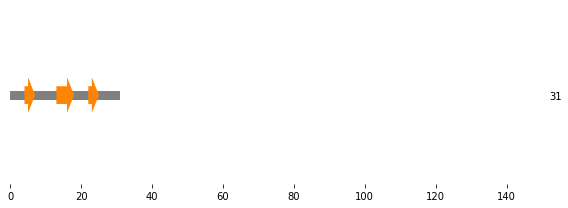

2L4J
2L4J E7FH70 A 188 218
2YSB


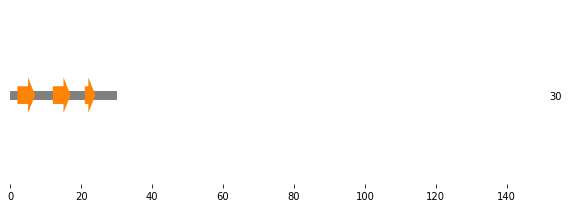

2N8S


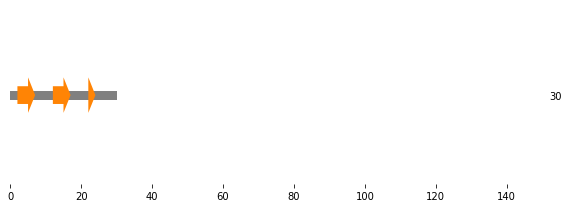

1I8G


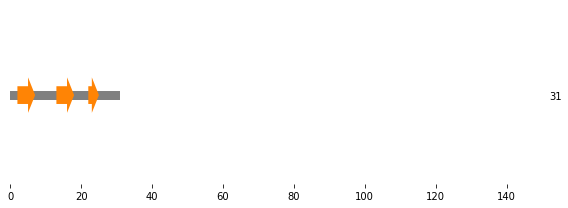

2YSC


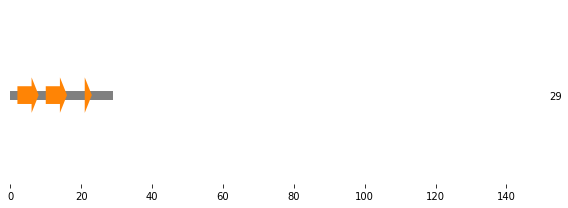

2M3O
2M3O P37088 W 423 453
1YW5


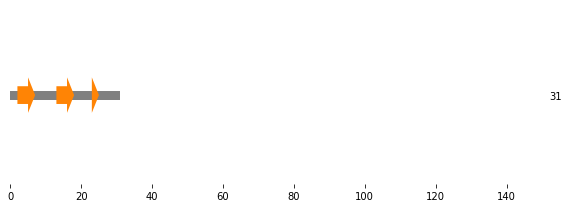

2JO9


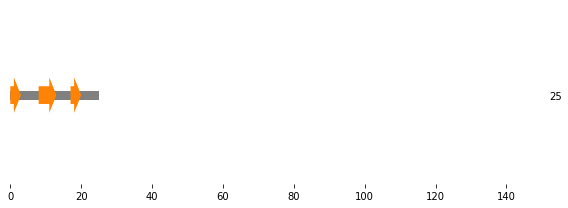

4LCD


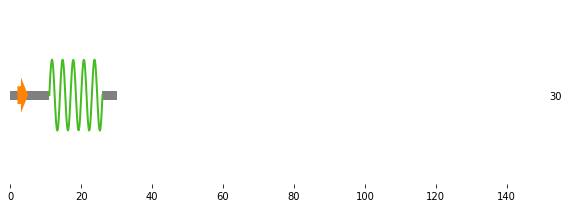

1E0L


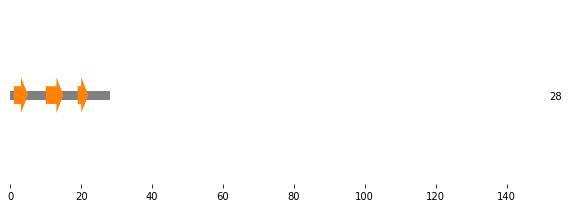

5B3Z


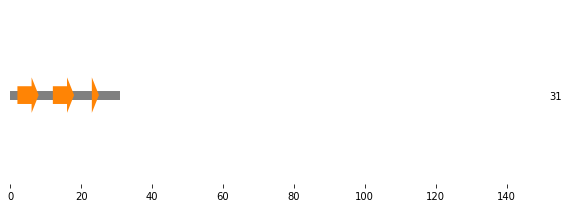

2JMF
2JMF Q32UW5 A 523 553
3L4H
3L4H Q76N89 A 1020 1050
1I5H
1I5H P37090 W 461 491
1I8H


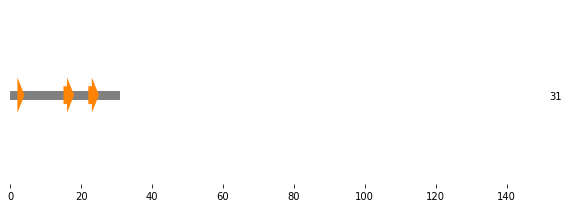

2YSG


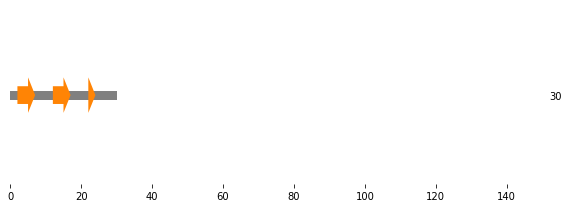

2KPZ


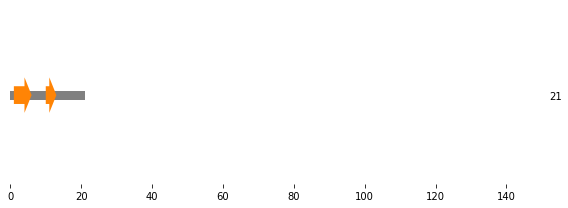

1O6W


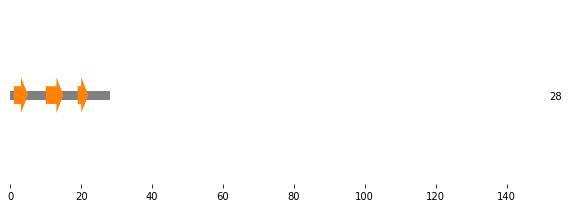

2YSH


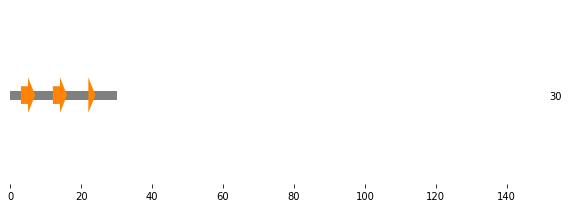

1TK7


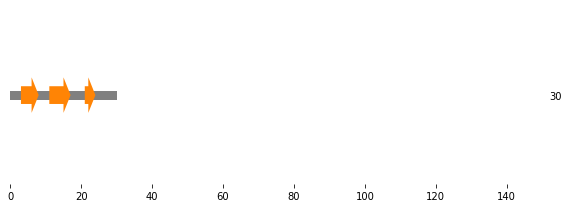

6J68


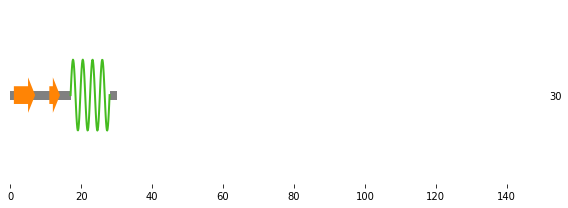

6N7P
6N7P P32605 J 397 425
6JJW


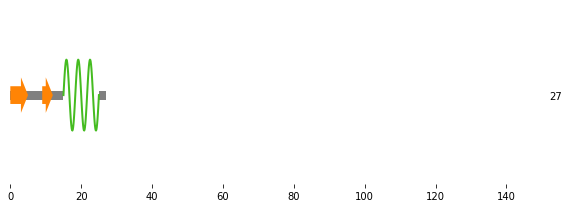

6JJY


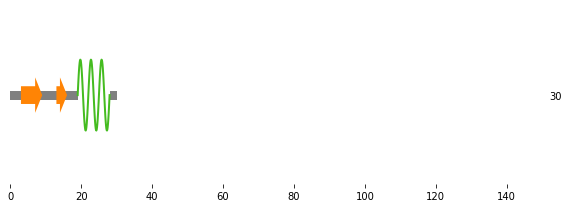

6JK1
6JK1 P46938 A 219 249
6JJX


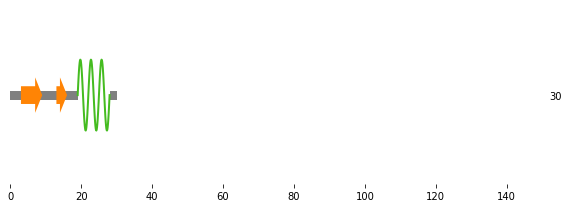

6JJZ
6JJZ Q80TS7 A 360 390


In [53]:
for pdb, pfam, c, start, end in structfam.values():
    try:
        print(pdb)
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        visualize_secondary_structure(sse, 0, 150)
        plt.show()
    except:
        print(pdb, pfam, c, start, end+1)

In [6]:
fetch_PDB('1YIU', 'A', 6, 35)

(array(['c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c',
        'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c',
        'c', 'c', 'c'], dtype='<U1'),
 <biotite.structure.AtomArray at 0x7f2e04c0a310>)

In [1]:
from biotite.structure.io.pdb import get_structure

In [2]:
get_structure('1YIU', 'A', 6, 35)

AttributeError: 'str' object has no attribute 'get_structure'